# House Prices Regression

This strategy will use neural networks with category embeddings to create features that will be used by subsequent models. Layer-1 models will be stacked together with a meta-learner. 

## Declare functions and load libraries

In [1]:
# future functions
from __future__ import print_function 

# core scipy and numpy
import numpy as np
import scipy as sp

# pandas 
import pandas as pd
from IPython.display import display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 135

# python helpers 
from collections import namedtuple
from copy import copy
from itertools import combinations, permutations

# encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Merge, Reshape
from keras.layers.embeddings import Embedding

# Cross validation 
from sklearn.model_selection import KFold

# visualizations
import seaborn as sns
import matplotlib 
%matplotlib inline

Using TensorFlow backend.


In [2]:
loadfile = lambda x: pd.read_csv(x, index_col=0)

# check column data for skew 
get_skew = lambda x: sp.stats.skewtest(x.dropna())>0.75

In [3]:
@np.vectorize
def categorize_4(x, s1, s2, s3):
    if x<s1:
        return '0'
    elif x>=s1 and x<s2:
        return '1'
    elif x>=s2 and x<s3:
        return '2'
    else:
        return '3'

In [4]:
Files = namedtuple('Files',['train','test'])
RawData = namedtuple('RawData',['train','test'])
FullData = namedtuple('FullData',['X','X_train_ids','X_test_ids','y'])
ProcessedData = namedtuple('ProcessedData',['X_train','y_train','X_test'])

## Preprocessing

### Load data
Store data inside of namedtuple objects to keep data organized.

In [5]:
# load raw data
rawfiles = Files(train='Data/train.csv.gz',
            test='Data/test.csv.gz')
raw = RawData(train=loadfile(rawfiles.train),
              test=loadfile(rawfiles.test))

# concatenate all data 
cols = [ c for c in raw.train.columns if c != 'SalePrice' ]
full = FullData(X = pd.concat((raw.train.loc[:, cols], raw.test)), 
                X_train_ids = raw.train.index,
                X_test_ids = raw.test.index,
                y = raw.train.SalePrice,)

In [6]:
full.X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
full.y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Classify data types

In [8]:
# categorical column list
numeric_categorical = [
    'MSSubClass',
    'YearBuilt',
    'YearRemodAdd',
    'MoSold',
    'YrSold',
    'GarageYrBlt',
    'OverallQual',
    'OverallCond',
    'MiscVal',
    'GarageCars',
    'Fireplaces',
]
categorical_cols = list(full.X.dtypes[full.X.dtypes == "object"].index)
categorical_cols += numeric_categorical
categorical_cols = [ c for c in categorical_cols ]

# continuous column list
continuous_cols = list(full.X.dtypes[full.X.dtypes != "object"].index)
continuous_cols = [ c for c in continuous_cols 
                       if c not in numeric_categorical 
                       and c!='SalePrice' ]

### Feature creation

In [9]:
# before 2009 flag 
full.X['Before2009'] = full.X.YrSold < 2009
categorical_cols += ['Before2009']

# quarter of year sold
full.X['QtrOfYearSold'] = full.X.MoSold.apply(lambda x: categorize_4(x, 4, 7, 10))
categorical_cols += ['QtrOfYearSold']

# percent of lot
full.X['PctOfLot'] = full.X.GrLivArea / full.X.LotArea
continuous_cols += ['PctOfLot']

# percent first floor of total
full.X['Pct1stFlr'] = full.X['1stFlrSF'] / full.X.GrLivArea
continuous_cols += ['Pct1stFlr']

# percent second floor of total
full.X['Pct2ndFlr'] = full.X['2ndFlrSF'] / full.X.GrLivArea
continuous_cols += ['Pct2ndFlr']

# percent basement of total
full.X['PctBasement'] = full.X.TotalBsmtSF / full.X.GrLivArea
continuous_cols += ['PctBasement']

# 2nd floor / 1st floor ratio
full.X['2nd1stRatio'] = full.X['2ndFlrSF'] / full.X['1stFlrSF']
continuous_cols += ['2nd1stRatio']

# Bathrooms per SF
full.X['BathPerSF'] = (full.X.FullBath+0.5*full.X.HalfBath+full.X.BsmtFullBath) / full.X.GrLivArea
continuous_cols += ['BathPerSF']

# Bedrooms per SF
full.X['BedroomPerSF'] = full.X.BedroomAbvGr / full.X.GrLivArea
continuous_cols += ['BedroomPerSF']

# Total rooms per SF
full.X['TotalRoomsPerSF'] = full.X.TotRmsAbvGrd / full.X.GrLivArea
continuous_cols += ['TotalRoomsPerSF']

# percent size of garage
full.X['PctGarage'] = full.X.GarageArea / full.X.GrLivArea
continuous_cols += ['PctGarage']

# ratio garage cars to area
full.X['GarageCarRatio'] = full.X.GarageCars / full.X.GarageArea
continuous_cols += ['GarageCarRatio']

# Frontage percent of lot area
full.X['FrontagePctArea'] = full.X.LotFrontage / full.X.LotArea
continuous_cols += ['FrontagePctArea']

## Impute missing values, append log-transforms

In [10]:
n, m = full.X.shape

# store important objects
label_encoders = {}
categorical_col_nums = []

# loop through columns and delete crap columns
for col, col_data in full.X.iteritems():
    
    # count the nulls
    nans = np.sum(col_data.isnull())
    if nans*1.0 / n > 0.3:
        
        # drop columns that suck
        del full.X[col]
        if col in categorical_cols:
            categorical_cols.remove(col)
        elif col in continuous_cols:    
            continuous_cols.remove(col)
        if col in numeric_categorical:
            numeric_categorical.remove(col)


# second loop through columns to process data 
for col, col_data in full.X.iteritems():
    
    # handle categorical data
    if col in categorical_cols:
        
        # impute missing values 
        col_data = col_data.fillna('Missing')

        # encode categorical values
        le = LabelEncoder()
        col_data = le.fit_transform(col_data)
        categorical_col_nums.append(full.X.columns.get_loc(col))
        label_encoders[col] = le

        # store column 
        full.X.loc[:, col] = col_data

    # handle numeric data
    else:

        # check skew 
        if get_skew(col_data):
            full.X.loc[:, col] = np.log1p(full.X[col])
            full.X.loc[:, col] = np.log1p(full.X[col])

        # handle nulls 
        nans = np.sum(col_data.isnull())
        if nans>0:
            full.X.loc[:, col] = full.X[col].fillna(np.mean(full.X[col].dropna()))

## Scale data, set up OHE 

### Scale X

In [11]:
# np version of only continous data
cdata = full.X.loc[:, continuous_cols].as_matrix()

# scaler
continous_scaler = StandardScaler()
c = continous_scaler.fit_transform(cdata)

# transform data in full dataset
full.X.loc[:, continuous_cols] = c

### Scale Y 

In [12]:
# transform Y variable 
y_scaler = MinMaxScaler()
ylog = np.log(full.y.as_matrix())
y_indices = full.y.index
y_scaled = y_scaler.fit_transform(ylog.reshape(-1,1))
full.y.loc[:] = y_scaled.ravel()

def rescale_y(y_scaled):
    return y_scaler.inverse_transform(y_scaled.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


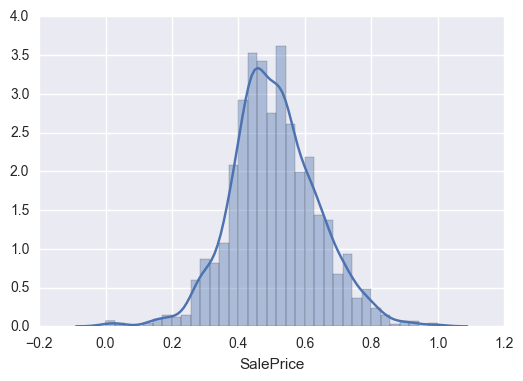

In [13]:
sns.distplot(full.y)

### One-hot encoder

In [14]:
# create one hot encoder
ohe = OneHotEncoder(categorical_features=categorical_col_nums)
_ = ohe.fit_transform(full.X.as_matrix())

## Neural Network model
Use categorical embedding, and then append embedding features into training dataset

### Declare default embedding sizes

In [15]:
# default sizing 
embedding_sizes = {}
for c in categorical_cols:
    unique_values = full.X[c].value_counts()
    m = unique_values.shape[0]
    new_m = m // 2
    embedding_sizes[c] = {'m':m,'new_m':new_m}

# custom sizes 
embedding_sizes['GarageYrBlt']['new_m'] = 4
embedding_sizes['YrSold']['new_m'] = 3
embedding_sizes['YearBuilt']['new_m'] = 30
embedding_sizes['YearRemodAdd']['new_m'] = 1
embedding_sizes['Neighborhood']['new_m'] = 3
embedding_sizes['MiscVal']['new_m'] = 1
embedding_sizes['MSSubClass']['new_m'] = 20
embedding_sizes['OverallQual']['new_m'] = 16
embedding_sizes['OverallCond']['new_m'] = 14

In [16]:
embedding_sizes

{'Before2009': {'m': 2, 'new_m': 1},
 'BldgType': {'m': 5, 'new_m': 2},
 'BsmtCond': {'m': 5, 'new_m': 2},
 'BsmtExposure': {'m': 5, 'new_m': 2},
 'BsmtFinType1': {'m': 7, 'new_m': 3},
 'BsmtFinType2': {'m': 7, 'new_m': 3},
 'BsmtQual': {'m': 5, 'new_m': 2},
 'CentralAir': {'m': 2, 'new_m': 1},
 'Condition1': {'m': 9, 'new_m': 4},
 'Condition2': {'m': 8, 'new_m': 4},
 'Electrical': {'m': 6, 'new_m': 3},
 'ExterCond': {'m': 5, 'new_m': 2},
 'ExterQual': {'m': 4, 'new_m': 2},
 'Exterior1st': {'m': 16, 'new_m': 8},
 'Exterior2nd': {'m': 17, 'new_m': 8},
 'Fireplaces': {'m': 5, 'new_m': 2},
 'Foundation': {'m': 6, 'new_m': 3},
 'Functional': {'m': 8, 'new_m': 4},
 'GarageCars': {'m': 7, 'new_m': 3},
 'GarageCond': {'m': 6, 'new_m': 3},
 'GarageFinish': {'m': 4, 'new_m': 2},
 'GarageQual': {'m': 6, 'new_m': 3},
 'GarageType': {'m': 7, 'new_m': 3},
 'GarageYrBlt': {'m': 104, 'new_m': 4},
 'Heating': {'m': 6, 'new_m': 3},
 'HeatingQC': {'m': 5, 'new_m': 2},
 'HouseStyle': {'m': 8, 'new_m': 4}

### Create embedding model

In [17]:
def nne_model(embedding_sizes,l1=64,l2=356,dropout=0.3):
    models = []

    # create embedding for each categorical feature
    for c in categorical_cols:

        # get sizes 
        m = embedding_sizes[c]['m']
        new_m = embedding_sizes[c]['new_m']

        # define model 
        entity_model = Sequential()
        entity_model.add(Embedding(m, new_m, input_length=1))
        entity_model.add(Reshape(target_shape=(new_m,)))

        # append to models
        models.append(entity_model)


    # add continuous data as one model
    _, m = full.X[continuous_cols].shape
    continuous_model = Sequential()
    continuous_model.add(Dense(m, input_dim=m))
    models.append(continuous_model)

    # create full embedding model 
    emb_model = Sequential()
    emb_model.add(Merge(models, mode='concat'))
    emb_model.add(Dropout(0.01))
    emb_model.add(Dense(l1, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(dropout))
    emb_model.add(Dense(l2, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(dropout))
    emb_model.add(Dense(1))
    emb_model.add(Activation('sigmoid'))
    emb_model.compile(loss='mean_squared_error', optimizer='adam')
    return copy(emb_model)

### Run model

In [18]:
def nn_preprocessing_X(X_dat):
    X_out = []
    
    # categorical columns
    for c in categorical_cols:
        d = X_dat.loc[:, c].as_matrix()
        X_out.append(d)
    
    # continuous columns
    continuous_dat = X_dat.loc[:, continuous_cols].as_matrix()
    
    X_out.append(continuous_dat)
    return X_out

def calc_rmsle(predictions, actual):
    y_p = rescale_y(predictions).reshape(-1,1)
    y_a = rescale_y(actual).reshape(-1,1)
    return np.sqrt(np.mean((y_p-y_a)**2))

In [19]:
def train_nne_model(embedding_sizes,l1=128,l2=128,dropout=0.3):
    # setup results array
    kf_train = np.zeros((X_train.shape[0],))

    # iterate through K-folds
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):

        # set up train and test data
        x_tr = nn_preprocessing_X(X_train.iloc[train_index])
        x_te = nn_preprocessing_X(X_train.iloc[test_index])
        y_tr = y_train.iloc[train_index].as_matrix()

        # train new model
        model = nne_model(embedding_sizes,l1=128,l2=128,dropout=0.3)
        model.fit(x_tr, y_tr,
                  nb_epoch = 16,
                  batch_size = 8,
                  verbose = 0)

        # make predictions
        kf_train[test_index] = model.predict(x_te).ravel()
    
    rmse = calc_rmsle(kf_train, y_train)
    del model
    del kf_train
    
    return rmse

In [ ]:
X_train = full.X.loc[full.X_train_ids, :]
y_train = full.y

NFOLDS = 4
s = 17
kf = KFold(n_splits=NFOLDS, 
           shuffle=True, 
           random_state=s)
np.random.seed(s)

model_architectures = list(permutations([ 64, 128, 356], 2))
vals = [ 2, 4, 6, 9, 12 ]
dropouts = [ 0.3 ]
results_emb = []

for v in vals:
    embedding_sizes['MoSold']['new_m'] = v
    rmse = train_nne_model(embedding_sizes, 64, 356, 0.3)
    results_emb.append((v,rmse)) 

In [ ]:
# results_arch_df = pd.DataFrame(results_arch,columns=['L1','L2','Dropout','RMSE'])
# results_arch_df['rank'] = sp.stats.rankdata(results_arch_df.RMSE, method='min')

results_emb_df = pd.DataFrame(results_emb,columns=['MoSold','RMSE'])
results_emb_df['rank'] = sp.stats.rankdata(results_emb_df.RMSE, method='min')

In [ ]:
results_emb_df